# K-Nearest Neighbors Homework Solutions
***
**Name**: $<$Rajarshi Basak$>$ 
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)

## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [6]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

from collections import Counter, defaultdict
from numpy import median

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [7]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [8]:
data = Numbers("../data/mnist.pklz")
print ("The number of examples in the training set are " , data.train_x.shape[0])
print ("The number of examples in the test set are " , data.test_x.shape[0])
print ("The number of pixels in each image are ", data.train_x.shape[1])

The number of examples in the training set are  50000
The number of examples in the test set are  10000
The number of pixels in each image are  784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [139]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        uniqvals, uniqcounts = np.unique(self._y, return_counts=True)
        return dict(zip(uniqvals, uniqcounts))

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        
        
        xd = Counter(self._y[neighbor_indices])
        
        ma = [x[0] for x in xd.most_common() 
                    if x[1] == max(xd.values())]
        
        
        maxt = 0
        maxv = 0
        
        for j in ma:
            if maxt < self._counts[j]:
                maxt = self._counts[j]
                maxv = j
       
        return maxv
    

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        _, pt = self._kdtree.query(example, self._k)
        return self.majority(pt.flatten())


    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """
        
        C = defaultdict(dict)
        dataind = 0
        
        for xx, yy in zip(test_x, test_y):
            try:
                C[yy][self.classify(xx)] += 1
            except KeyError:
                C[yy][self.classify(xx)] = 1 
        
        return C 
    
    
            
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        confusionmatrix = C
        total = 0
        correct = 0
        for ii in confusionmatrix:
            total += sum(confusionmatrix[ii].values())
            correct += confusionmatrix[ii].get(ii, 0)

        if total:
            return float(correct) / float(total)
        else:
            return 0.0
        #print (np.sum(C.diagonal()) / C.sum())
        #return np.sum(C.diagonal()) / C.sum()

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [140]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)
       
        
        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner(verbosity=2).run(tests_to_run)

test0 (__main__.TestKnn) ... ok
test1 (__main__.TestKnn) ... ok
test2 (__main__.TestKnn) ... ok
test3 (__main__.TestKnn) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.019s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

For k = 1
The accuracy for 50 training examples is 0.6433
The accuracy for 100 training examples is 0.6923
The accuracy for 200 training examples is 0.7644
The accuracy for 400 training examples is 0.8319
The accuracy for 600 training examples is 0.8562
The accuracy for 800 training examples is 0.8729
The accuracy for 1000 training examples is 0.882
The accuracy for 2000 training examples is 0.9102
The accuracy for 3000 training examples is 0.9234
The accuracy for 4000 training examples is 0.9324
The accuracy for 5000 training examples is 0.9388
For k = 3
The accuracy for 50 training examples is 0.5548
The accuracy for 100 training examples is 0.6472
The accuracy for 200 training examples is 0.7162
The accuracy for 400 training examples is 0.8026
The accuracy for 600 training examples is 0.8332
The accuracy for 800 training examples is 0.8571
The accuracy for 1000 training examples is 0.869
The accuracy for 2000 training examples is 0.9052
The accuracy for 3000 training examples is 0.9

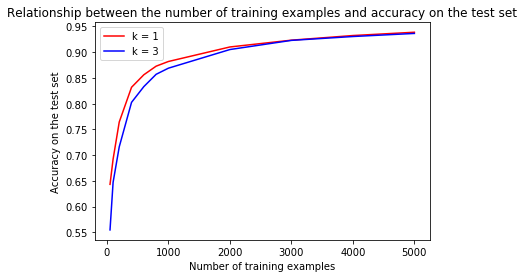

In [117]:
k1accur = []
k3accur = []
traindata = [50,100,200,400,600,800,1000,2000,3000,4000,5000]
for k in [1,3]:
    print ("For k =",k)
    for dt in [50,100,200,400,600,800,1000,2000,3000,4000,5000]:
        #print (dt)
        knnlabel = Knearest(data.train_x[:dt],data.train_y[:dt],k)
        confmat = knnlabel.confusion_matrix(data.test_x,data.test_y)
        accu = knnlabel.accuracy(confmat)
        print("The accuracy for" ,dt, "training examples is" ,accu)
        #k1[dt] = accu
        if k == 1:
            k1accur.append(accu)
        if k == 3:
            k3accur.append(accu)
            
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy on the test set')
plt.title('Relationship between the number of training examples and accuracy on the test set')
plt.plot(traindata, k1accur, 'r', label = 'k = 1') 
plt.plot(traindata, k3accur, 'b', label = 'k = 3') 
plt.legend()
plt.show()


**Comments for Part A** : For k = 1, the accuracies for training examples from 50 to 10000 were calculated, and it was observed that there was a steep rise in accuracy as the number of training examples increased from 50 to 500, and then a more gradual rise for number of training examples from 500 to around 2000, and finally a slow rise for the number of training examples from 2000 to 5000, as shown by the plot above. For k = 3, the accuracies were initially slightly lower than that for k = 1 (for training examples from 1000 to 5000), and then almost identical to those for k = 1 for higher numbers of training examples.

**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

For number of training examples 50
The accuracy for k = 1 is 0.6433
The accuracy for k = 2 is 0.546
The accuracy for k = 3 is 0.5548
The accuracy for k = 4 is 0.5438
The accuracy for k = 5 is 0.5198
The accuracy for k = 6 is 0.4952
The accuracy for k = 7 is 0.467
The accuracy for k = 8 is 0.4456
The accuracy for k = 9 is 0.4288
The accuracy for k = 10 is 0.4143
For number of training examples 500
The accuracy for k = 1 is 0.8458
The accuracy for k = 2 is 0.7934
The accuracy for k = 3 is 0.8198
The accuracy for k = 4 is 0.8061
The accuracy for k = 5 is 0.8129
The accuracy for k = 6 is 0.8016
The accuracy for k = 7 is 0.8024
The accuracy for k = 8 is 0.7927
The accuracy for k = 9 is 0.7949
The accuracy for k = 10 is 0.7842
For number of training examples 5000
The accuracy for k = 1 is 0.9388
The accuracy for k = 2 is 0.9195
The accuracy for k = 3 is 0.9365
The accuracy for k = 4 is 0.9351
The accuracy for k = 5 is 0.9356
The accuracy for k = 6 is 0.9331
The accuracy for k = 7 is 0.9332
T

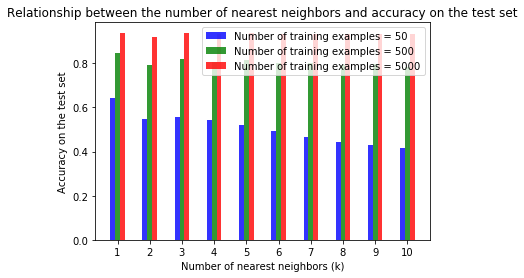

In [118]:
d1accur = []
d2accur = []
d3accur = []

for dt in [50,500,5000]:
    print ("For number of training examples" , dt)
    for k in range (1,11):
        knnlabel = Knearest(data.train_x[:dt],data.train_y[:dt],k)
        confmat = knnlabel.confusion_matrix(data.test_x,data.test_y)
        accu = knnlabel.accuracy(confmat)
        print("The accuracy for k =" ,k, "is" ,accu)
        if dt == 50:
            d1accur.append(accu)
        if dt == 500:
            d2accur.append(accu)
        if dt == 5000:
            d3accur.append(accu)
            
n_groups = 10

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, d1accur, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Number of training examples = 50')

rects2 = plt.bar(index + bar_width, d2accur, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Number of training examples = 500')

rects3 = plt.bar(index + 2*bar_width, d3accur, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Number of training examples = 5000')

plt.xlabel('Number of nearest neighbors (k)')
plt.ylabel('Accuracy on the test set')
plt.title('Relationship between the number of nearest neighbors and accuracy on the test set')
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend()
 
plt.show()            

**Comments for Part B** : The accuracies were calculated for number of training examples = 50, 500, 5000, and it was observed that each of the three cases, the accuracy dropped slightly from k = 1 to k = 2, and increased slightly from k = 2 to k = 3, and then dropped gradually as the value of k was increased for a small number of training examples (say 50), but increased slightly when the number of training examples was considerably larger (5000, for example), as shown in the plot above.

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

In [108]:
k = 10
tdp = 10000
knnlabel = Knearest(data.train_x[:tdp],data.train_y[:tdp],k)
confmat = knnlabel.confusion_matrix(data.test_x,data.test_y)
accu = knnlabel.accuracy(confmat)

print("\t" + "\t".join(str(j) for j in range(10)))
print("".join(["-"] * 85))
for ii in range(10):
            print("%i:\t" % ii + "\t".join(str(confmat[ii].get(x, 0)) for x in range(10)))
            #print("Accuracy: %f" % knnlabel.accuracy(confmat))

	0	1	2	3	4	5	6	7	8	9
-------------------------------------------------------------------------------------
0:	981	1	2	0	1	0	3	2	0	1
1:	0	1059	3	0	0	0	0	2	0	0
2:	6	26	909	7	2	1	4	27	4	4
3:	1	3	3	992	0	5	1	6	10	9
4:	0	27	0	0	905	0	4	3	0	44
5:	5	8	0	29	3	825	27	5	5	8
6:	5	2	0	0	0	2	958	0	0	0
7:	1	24	1	0	5	0	0	1050	0	9
8:	10	34	2	25	4	14	8	12	875	25
9:	9	7	1	12	11	2	0	27	1	891


**Comments for Part C** : In the confusion matrix for the test set shown above for 10000 examples from the training data and k = 10, the rows represent the true labels whie the columns are the predicted labels. It is observed that
<br>
(1) '2' is misclassified often as a '1' or a '7'
<br>
(2) '4' is misclassified often as a '1' or a '9'
<br>
(3) '5' is misclassified often as a '3' or a '6'
<br>
(4) '7' is misclassified often as a '1'
<br>
(5) '8' is misclassified often as a '1', a '3' or a '9'
<br>
(6) '9' is misclassified often as a '7' 

true label: 5


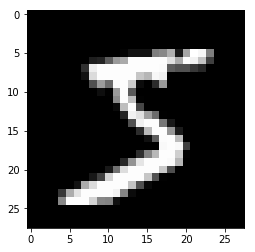

In [141]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');
    
view_digit(data.train_x[0,:], data.train_y[0])



true label: 4


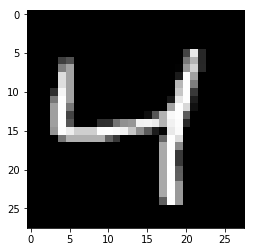

In [142]:
view_digit(data.train_x[2,:], data.train_y[2])

true label: 9


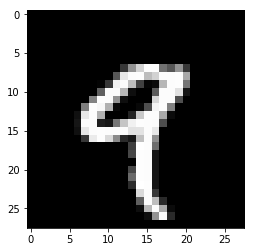

In [143]:
view_digit(data.train_x[4,:], data.train_y[4])

true label: 2


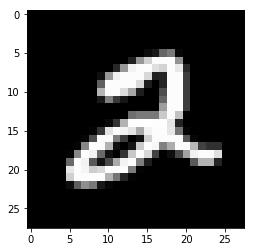

In [144]:
view_digit(data.train_x[5,:], data.train_y[5])

true label: 7


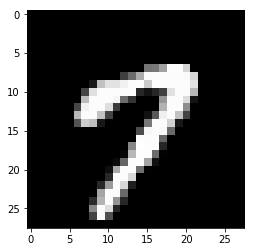

In [145]:
view_digit(data.train_x[15,:], data.train_y[15])

**Error Analysis** :As shown above, the way a '4' is written resembles somewhat the way a '9' is written, which explains why a '4' can be misclassified as a '9'. Similarly, as shown above, the way a '2' is written resembles somewhat the way a '7' is written, which explains why a '2' can be misclassified as a '7'.